In [1]:
!pip install scikit-learn

In [44]:
import pandas as pd
import numpy as np
import pylab as plt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy
from scipy import stats
import sklearn
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR, SVC, LinearSVC, LinearSVR
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2, f_classif, VarianceThreshold, f_regression
import numpy as np
import matplotlib.pyplot as plt
from string import ascii_letters
import seaborn as sns
import warnings

np.warnings.filterwarnings('ignore')
np.seterr(all='ignore')
sns.set(style="white")
warnings.filterwarnings("ignore",category=FutureWarning)

RNG=42

# Изучение восстановление пациентов после инсульта

Цель исследования: 

  * найти такие признаки, которые коррелируют с положительной динамикой по шкале Ренка(?);
  * найти такие признаки, которые коррелируют с отрицательной динамикой.

The goal of the reasearch - to find clinical features, correlated with a positive outcome (1)  of the disease 0-2 Renk score. 

Then the negative outacome, or poor neurological rehabillitation (0)  ranked as 3-6 Renk.

In [45]:
df = pd.read_csv('stroke_rehab_03.2019.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,ПОЛ,ВОЗРАСТ,Продолжительность образования (годы),Метобол с-м,Нарушение угл обмена,СД,Тяжесть АГ в анамнезе,Длительность АГ,ТИА,КУРЕНИЕ,...,Пирамидный с-м,ИАШОД10 ЦПРиН,Симптомы орального автоматизма,Поза Вернике-Манна,ПВИ_1.0,ПВИ_2.0,ПВИ_3.0,ПВИ_6.0,target,target binar
0,1.0,58.0,12.0,0.0,1.0,0.0,2.0,10.0,0.0,1.0,...,2.0,3.0,1.0,1.0,0,1,0,0,3.0,1.0
1,0.0,NaN,17.0,0.0,0.0,NaN,4.0,9.0,1.0,1.0,...,3.0,6.0,1.0,0.0,1,0,0,0,3.0,1.0
2,0.0,55.0,10.0,0.0,1.0,NaN,2.0,3.0,0.0,1.0,...,5.0,6.0,1.0,1.0,0,1,0,0,4.0,1.0
3,0.0,59.0,18.0,0.0,0.0,0.0,2.0,6.0,0.0,1.0,...,2.0,3.0,1.0,0.0,1,0,0,0,2.0,0.0
4,0.0,72.0,20.0,0.0,1.0,0.0,4.0,10.0,0.0,1.0,...,2.0,2.0,1.0,0.0,0,0,1,0,3.0,1.0


In [46]:
df.columns

Index(['ПОЛ', 'ВОЗРАСТ ', 'Продолжительность образования  (годы)',
       'Метобол с-м', 'Нарушение угл обмена', 'СД', 'Тяжесть АГ в анамнезе',
       'Длительность АГ ', 'ТИА', 'КУРЕНИЕ', 'АЛКОГОЛЬ',
       'Неревматическая фибрилляция предсердий (МКБ I48)',
       'Другие нарушение сердечного ритма', 'ЗАБОЛЕ-ВАНИЯ СЕРДЦА',
       'Количество потенциальных источников кардиогенной эмболии ', 'ИМТ',
       'ОЖИРЕНИЕ', 'Низкая физическая активность ', 'ХроничскийСтресс',
       'Количество НФР ', 'Общее Количествово ФР', 'Объём очага см3',
       ' АТ МАГ', 'Дис липидемия', 'ГТИ', 'Двигательные нарушения ОНМК',
       'логопед занятия ОНМК', 'СТЛ', 'ЛТЛ', 'NIHSS     1 сутки',
       'NIHSS    21 сутки ', 'Bаrtеl      21 сутки', 'Renk 21 сутки',
       'ИМР поступление ЦПРиН ', 'NIHSS  поступл ЦПРиН ',
       'M-Ash рука (поступление) ЦПРиН  ', 'M-Ash нога (поступление) ЦПРиН ',
       'Вейс рука (поступление) ЦПРиН ', 'Вейс нога (поступление) ЦПРиН ',
       'Индекс Хаузера ЦПРиН ', 'Инд

In [47]:
np.unique(df.target, return_counts=True)

(array([1., 2., 3., 4., 5., 6.]), array([ 1, 19, 21,  7,  1,  2]))

In [48]:
df['target binar'].head()

0    1.0
1    1.0
2    1.0
3    0.0
4    1.0
Name: target binar, dtype: float64

## Подсчет статистик по датасету

Для категориальных переменных считаем проценты, для численных переменных - квантили.

In [49]:
features = ['ПОЛ', 'ВОЗРАСТ ', 'Продолжительность образования  (годы)',
            'Метобол с-м', 'Нарушение угл обмена', 'СД', 'Тяжесть АГ в анамнезе',
            'Длительность АГ ', 'ТИА', 'КУРЕНИЕ', 'АЛКОГОЛЬ',
            'Неревматическая фибрилляция предсердий (МКБ I48)',
            'Другие нарушение сердечного ритма', 'Низкая физическая активность ', 
            'ХроничскийСтресс', 'Количество потенциальных источников кардиогенной эмболии ', 'ИМТ', 
            'Количество НФР ', 'Дис липидемия', 'Общее Количествово ФР',
            'Объём очага см3' , 'ГТИ', 'Двигательные нарушения ОНМК', 'логопед занятия ОНМК', 
            'СТЛ', 'ЛТЛ', 'NIHSS     1 сутки', 'NIHSS    21 сутки ', 'Bаrtеl      21 сутки',
            'Renk 21 сутки', 'ИМР поступление ЦПРиН ', 'NIHSS  поступл ЦПРиН ',
            'M-Ash рука (поступление) ЦПРиН  ', 'M-Ash нога (поступление) ЦПРиН ',
            'Вейс рука (поступление) ЦПРиН ', 'Вейс нога (поступление) ЦПРиН ',
            'Индекс Хаузера ЦПРиН ', 'Индекс Холдена ЦПРиН ', 'Bаrtеl      поступление ЦПРиН ', 
            'Псевдобульбарный с-м ЦПРиН ', 'ИАШОД10 ЦПРиН ', 'Симптомы орального автоматизма', 
            'Поза Вернике-Манна',  'ПВИ_2.0','ПВИ_1.0','ПВИ_3.0', 'ПВИ_6.0', ' АТ МАГ']

In [50]:
aggregated_stats = [
    'Клинические данные',
    'Количество записей',
    'Количество положительных/Медиана',
    'Процент положительных,%/Квантиль [0.25,0.75]'
]

def mean_stats(df_full, statistics, columns, aggregated_stats):
    for i in columns:
        unique, counts = np.unique(df_full[i].dropna(), return_counts=True)
        if len(unique) < 3:
            statistics=statistics.append({aggregated_stats[0]: i,
                                          aggregated_stats[1]: counts.sum(),
                                          aggregated_stats[2]: counts[1],
                                          aggregated_stats[3]: int(counts[1] / counts.sum() * 100)}, 
                                             ignore_index=True)
        else:
            statistics=statistics.append({aggregated_stats[0]: i,
                                          aggregated_stats[1]: counts.sum(), 
                                          aggregated_stats[2]: round(np.median(df_full[i].dropna()), 2),
                                          aggregated_stats[3]: np.asarray(round(df_full[i].quantile([0.25, 0.75]), 2))},
                                          ignore_index=True)  
    return statistics

In [51]:
statistics_full = pd.DataFrame(columns=aggregated_stats)
statistics_full = mean_stats(df, statistics_full, columns=features, aggregated_stats=aggregated_stats)

In [52]:
statistics_full.head()

,Клинические данные,Количество записей,Количество положительных/Медиана,"Процент положительных,%/Квантиль [0.25,0.75]"
0,ПОЛ,51,25,49
1,ВОЗРАСТ,50,59,"[51.25, 63.0]"
2,Продолжительность образования (годы),51,12,"[10.0, 16.5]"
3,Метобол с-м,50,10,20
4,Нарушение угл обмена,51,27,52


### Посчитаем статистики отдельно для двух групп 1 и 2 

In [53]:
def targeted_stats(df_full, statistics, columns, aggregated_stats):
    
    for i in columns:
        unique, counts = np.unique(df_full[i].dropna(), return_counts=True)
        if len(unique) < 3:
            try:
                statistics=statistics.append({
                                          aggregated_stats[0]: counts[1],
                                          aggregated_stats[1]: int(counts[1] / counts.sum() * 100)}, 
                                             ignore_index=True)
            
            
            except:
                statistics=statistics.append({
                                          aggregated_stats[0]: 0,
                                          aggregated_stats[1]: 0}, 
                                             ignore_index=True)
                
        else:
             statistics=statistics.append({
                                           aggregated_stats[0]: round(np.median(df_full[i].dropna()), 2),
                                           aggregated_stats[1]: np.asarray(round(df_full[i].quantile([0.25, 0.75]),2))}, 
                                             ignore_index=True)
    return statistics

In [54]:
aggregated_stats = ['Количество положительных/Медиана mRS 0–2',
                    'Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2']

In [55]:
df_pos = df[df['target binar']==1]
statistics_pos = pd.DataFrame(columns=aggregated_stats)
statistics_pos = targeted_stats(df_pos, statistics_pos, columns=features, aggregated_stats=aggregated_stats)
statistics_pos.head()

,Количество положительных/Медиана mRS 0–2,"Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2"
0,15,48
1,57,"[51.0, 62.75]"
2,12,"[11.0, 16.5]"
3,5,16
4,17,54


In [56]:
# для второй группы
df_neg = df[df['target binar']==0]
aggregated_stats=['Количество положительных/Медиана mRS 3–6',
                  'Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6']

In [57]:
statistics_neg = pd.DataFrame(columns=aggregated_stats)
statistics_neg = targeted_stats(df_neg, statistics_neg, columns=features, aggregated_stats=aggregated_stats)
statistics_neg.head()

,Количество положительных/Медиана mRS 3–6,"Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6"
0,10,50
1,59.5,"[56.75, 65.0]"
2,11.5,"[10.0, 16.25]"
3,5,25
4,10,50


In [58]:
statistics_neg.shape, statistics_pos.shape, statistics_full.shape

((48, 2), (48, 2), (48, 4))

In [59]:
# и вот мы получили таблицу 1 как в статье, почти, осталось только посчитать p -value по группам
statistics = pd.concat([statistics_full, statistics_pos, statistics_neg], axis=1)
statistics.head()

,Клинические данные,Количество записей,Количество положительных/Медиана,"Процент положительных,%/Квантиль [0.25,0.75]",Количество положительных/Медиана mRS 0–2,"Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2",Количество положительных/Медиана mRS 3–6,"Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6"
0,ПОЛ,51,25,49,15,48,10,50
1,ВОЗРАСТ,50,59,"[51.25, 63.0]",57,"[51.0, 62.75]",59.5,"[56.75, 65.0]"
2,Продолжительность образования (годы),51,12,"[10.0, 16.5]",12,"[11.0, 16.5]",11.5,"[10.0, 16.25]"
3,Метобол с-м,50,10,20,5,16,5,25
4,Нарушение угл обмена,51,27,52,17,54,10,50


#### Пример exact fisher test 

In [60]:
df.shape

(51, 53)

In [61]:
table = df.groupby(by=['target binar'])['ПОЛ'].sum()
print(table)

target binar
0.0    10.0
1.0    15.0
Name: ПОЛ, dtype: float64


In [62]:
oddsratio, pvalue = stats.fisher_exact(np.array([[31, 15],
                                                 [20, 10]]))
print("OddsR: ", oddsratio, "p-Value:", pvalue)

OddsR:  1.0333333333333334 p-Value: 1.0


#### Добавим вероятности, для этого нужно будет заполнить пропуски

In [63]:
dropna = False

In [64]:
df = df.apply(pd.to_numeric)
if dropna:
    df.dropna(inplace=True)
else:
    inputer = SimpleImputer(strategy='median')
    df[features] = inputer.fit_transform(df[features])

## Считаем статистику в истинных баллах Renk

In [65]:
from scipy.stats import mannwhitneyu, ttest_ind, fisher_exact

def mannwhitneyu_Xy(X, y):
    p_values = []
    stats = []
    for col in X.columns:
        stat, p_val = mannwhitneyu(X[col], y)
        stats.append(stat); p_values.append(p_val)
        
    return np.array(stats), np.array(p_values)


def ttest_ind_Xy(X, y):
    p_values = []
    stats = []
    for col in X.columns:
        stat, p_val = ttest_ind(X[col], y)
        stats.append(stat); p_values.append(p_val)
        
    return np.array(stats), np.array(p_values)

def exact_fisher_test(X):
    p_values = []
    stats = []
    for i, row in X.iterrows():
        oddsratio, p_val = fisher_exact(np.array([[31, row['Количество положительных/Медиана mRS 0–2']], 
                                                  [20, row['Количество положительных/Медиана mRS 3–6']]]))
        
        stats.append(oddsratio); p_values.append(p_val)
    return np.array(stats), np.array(p_values)

In [66]:
X = df[features][df['target'].notna()]
y = df['target'][df['target'].notna()]

In [67]:
statistics=pd.concat([statistics, pd.DataFrame(chi2(X, y)[1],
                                                    columns=['mRS ch2 p-value'])], axis=1)
statistics=pd.concat([statistics, pd.DataFrame(chi2(X, y)[0],
                                                    columns=['mRS ch2 statistics'])], axis=1)

In [68]:
statistics[statistics['mRS ch2 p-value'] < 0.05].head()

,Клинические данные,Количество записей,Количество положительных/Медиана,"Процент положительных,%/Квантиль [0.25,0.75]",Количество положительных/Медиана mRS 0–2,"Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2",Количество положительных/Медиана mRS 3–6,"Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6",mRS ch2 p-value,mRS ch2 statistics
1,ВОЗРАСТ,50,59,"[51.25, 63.0]",57,"[51.0, 62.75]",59.5,"[56.75, 65.0]",5.701160e-03,16.436973
7,Длительность АГ,51,6,"[5.0, 10.0]",7,"[3.5, 10.0]",5.5,"[5.0, 10.5]",3.532516e-03,17.572673
20,Объём очага см3,34,42,"[22.0, 56.5]",50,"[31.75, 57.75]",25,"[11.5, 51.25]",1.436078e-47,229.402897
26,NIHSS 1 сутки,51,12,"[8.5, 17.0]",14,"[9.0, 19.0]",9,"[7.0, 13.25]",2.836341e-09,48.478500
27,NIHSS 21 сутки,51,8,"[7.0, 13.5]",12,"[7.0, 15.0]",7,"[5.75, 10.0]",3.906619e-08,42.880702


In [69]:
X.shape

(51, 48)

In [70]:
# anova/ftest
statistics = pd.concat([statistics,pd.DataFrame(f_regression(X, y)[1],
                                                columns=['mRS ftest p-value'])], axis=1)

statistics = pd.concat([statistics,pd.DataFrame(f_regression(X, y)[0],
                                                columns=['mRS ftest statistics'])], axis=1)

In [71]:
# ну тут потому что хрень - курение это бинарное. тут нужно exact делать
statistics[statistics['mRS ftest p-value'] < 0.05].head()

,Клинические данные,Количество записей,Количество положительных/Медиана,"Процент положительных,%/Квантиль [0.25,0.75]",Количество положительных/Медиана mRS 0–2,"Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2",Количество положительных/Медиана mRS 3–6,"Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6",mRS ch2 p-value,mRS ch2 statistics,mRS ftest p-value,mRS ftest statistics
9,КУРЕНИЕ,51,31,60,17,54,14,70,8.094285e-01,2.278438,0.035955,4.651757
13,Низкая физическая активность,51,40,78,20,64,0,0,8.169576e-01,2.226786,0.012679,6.696071
23,логопед занятия ОНМК,51,27,52,14,45,13,65,7.739557e-01,2.516848,0.028728,5.078787
25,ЛТЛ,51,3,5,3,9,0,0,1.199778e-01,8.738095,0.009107,7.375591
26,NIHSS 1 сутки,51,12,"[8.5, 17.0]",14,"[9.0, 19.0]",9,"[7.0, 13.25]",2.836341e-09,48.478500,0.000152,16.857433


In [72]:
# mannwhitney
statistics = pd.concat([statistics,pd.DataFrame(mannwhitneyu_Xy(X, y)[1],
                                                columns=['mRS mannwhitneyu p-value'])], axis=1)

statistics = pd.concat([statistics,pd.DataFrame(mannwhitneyu_Xy(X, y)[0],
                                                columns=['mRS mannwhitneyu statistics'])], axis=1)

In [73]:
statistics[statistics['mRS mannwhitneyu p-value'] < 0.05].head()

,Клинические данные,Количество записей,Количество положительных/Медиана,"Процент положительных,%/Квантиль [0.25,0.75]",Количество положительных/Медиана mRS 0–2,"Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2",Количество положительных/Медиана mRS 3–6,"Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6",mRS ch2 p-value,mRS ch2 statistics,mRS ftest p-value,mRS ftest statistics,mRS mannwhitneyu p-value,mRS mannwhitneyu statistics
0,ПОЛ,51,25,49,15,48,10,50,0.951052,1.133985,0.772943,0.084174,5.050036e-19,12.5
1,ВОЗРАСТ,50,59,"[51.25, 63.0]",57,"[51.0, 62.75]",59.5,"[56.75, 65.0]",0.005701,16.436973,0.671889,0.181575,8.913566e-19,0.0
2,Продолжительность образования (годы),51,12,"[10.0, 16.5]",12,"[11.0, 16.5]",11.5,"[10.0, 16.25]",0.930513,1.342357,0.681180,0.170828,8.039534e-19,0.0
3,Метобол с-м,50,10,20,5,16,5,25,0.323068,5.830451,0.530880,0.398343,7.547635e-20,5.0
4,Нарушение угл обмена,51,27,52,17,54,10,50,0.755289,2.639933,0.551958,0.358755,5.240134e-19,13.5


In [74]:
# ttest
statistics = pd.concat([statistics,pd.DataFrame(ttest_ind_Xy(X, y)[1],
                                                columns=['mRS ttest p-value'])], axis=1)

statistics = pd.concat([statistics,pd.DataFrame(ttest_ind_Xy(X, y)[0],
                                                columns=['mRS ttest statistics'])], axis=1)

In [75]:
statistics[statistics['mRS ttest p-value'] < 0.05].head()

,Клинические данные,Количество записей,Количество положительных/Медиана,"Процент положительных,%/Квантиль [0.25,0.75]",Количество положительных/Медиана mRS 0–2,"Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2",Количество положительных/Медиана mRS 3–6,"Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6",mRS ch2 p-value,mRS ch2 statistics,mRS ftest p-value,mRS ftest statistics,mRS mannwhitneyu p-value,mRS mannwhitneyu statistics,mRS ttest p-value,mRS ttest statistics
0,ПОЛ,51,25,49,15,48,10,50,0.951052,1.133985,0.772943,0.084174,5.050036e-19,12.5,1.561008e-27,-15.095126
1,ВОЗРАСТ,50,59,"[51.25, 63.0]",57,"[51.0, 62.75]",59.5,"[56.75, 65.0]",0.005701,16.436973,0.671889,0.181575,8.913566e-19,0.0,4.273548e-61,37.861798
2,Продолжительность образования (годы),51,12,"[10.0, 16.5]",12,"[11.0, 16.5]",11.5,"[10.0, 16.25]",0.930513,1.342357,0.681180,0.170828,8.039534e-19,0.0,2.267778e-40,22.161750
3,Метобол с-м,50,10,20,5,16,5,25,0.323068,5.830451,0.530880,0.398343,7.547635e-20,5.0,2.061404e-32,-17.610477
4,Нарушение угл обмена,51,27,52,17,54,10,50,0.755289,2.639933,0.551958,0.358755,5.240134e-19,13.5,4.816685e-27,-14.852213


In [76]:
# exact_fisher_test
statistics = pd.concat([statistics,pd.DataFrame(exact_fisher_test(statistics)[1],
                                                columns=['mRS exact_fisher p-value'])], axis=1)

statistics = pd.concat([statistics,pd.DataFrame(exact_fisher_test(statistics)[0],
                                                columns=['mRS exact_fisher statistics'])], axis=1)

In [77]:
statistics[statistics['mRS exact_fisher p-value'] < 0.05].head()

,Клинические данные,Количество записей,Количество положительных/Медиана,"Процент положительных,%/Квантиль [0.25,0.75]",Количество положительных/Медиана mRS 0–2,"Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2",Количество положительных/Медиана mRS 3–6,"Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6",mRS ch2 p-value,mRS ch2 statistics,mRS ftest p-value,mRS ftest statistics,mRS mannwhitneyu p-value,mRS mannwhitneyu statistics,mRS ttest p-value,mRS ttest statistics,mRS exact_fisher p-value,mRS exact_fisher statistics
13,Низкая физическая активность,51,40,78,20,64,0,0,0.816958,2.226786,0.012679,6.696071,1.958099e-19,20.0,1.183602e-24,-13.686491,0.000387,0.0
18,Дис липидемия,51,49,96,29,93,0,0,0.999763,0.116618,0.868881,0.027538,2.382463e-20,24.5,7.532091e-24,-13.301670,0.000027,0.0


## Считаем статистику в бинарных баллах Renk

In [78]:
X = df[features][df['target'].notna()]
y = df['target binar'][df['target binar'].notna()]

In [79]:
statistics = pd.concat([statistics,
                       pd.DataFrame(chi2(X, y)[1],
                                   columns=['mRS ch2 binar p-value'])], axis=1)
statistics = pd.concat([statistics,
                       pd.DataFrame(f_classif(X, y)[1],
                                   columns=['mRS ftest binar p-value'])], axis=1)

statistics = pd.concat([statistics, 
                       pd.DataFrame(mannwhitneyu_Xy(X, y)[1],
                                    columns=['mRS mannwhitneyu binar p-value'])], axis=1)

statistics = pd.concat([statistics,
                        pd.DataFrame(ttest_ind_Xy(X, y)[1],
                                     columns=['mRS ttest binar p-value'])], axis=1)

statistics = pd.concat([statistics,
                        pd.DataFrame(exact_fisher_test(statistics)[1],
                                     columns=['mRS exact_fisher binar p-value'])], axis=1)

In [80]:
statistics[statistics['mRS ftest binar p-value']<0.05].head()

,Клинические данные,Количество записей,Количество положительных/Медиана,"Процент положительных,%/Квантиль [0.25,0.75]",Количество положительных/Медиана mRS 0–2,"Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2",Количество положительных/Медиана mRS 3–6,"Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6",mRS ch2 p-value,mRS ch2 statistics,...,mRS mannwhitneyu statistics,mRS ttest p-value,mRS ttest statistics,mRS exact_fisher p-value,mRS exact_fisher statistics,mRS ch2 binar p-value,mRS ftest binar p-value,mRS mannwhitneyu binar p-value,mRS ttest binar p-value,mRS exact_fisher binar p-value
13,Низкая физическая активность,51,40,78,20,64,0,0,8.169576e-01,2.226786,...,20.0,1.183602e-24,-13.686491,0.000387,0.000000,1.624132e-01,0.002083,2.719370e-02,5.341367e-02,0.000387
20,Объём очага см3,34,42,"[22.0, 56.5]",50,"[31.75, 57.75]",25,"[11.5, 51.25]",1.436078e-47,229.402897,...,47.0,1.310538e-17,10.400846,0.571175,0.775000,1.046927e-19,0.032829,3.311482e-19,7.407956e-19,0.571175
26,NIHSS 1 сутки,51,12,"[8.5, 17.0]",14,"[9.0, 19.0]",9,"[7.0, 13.25]",2.836341e-09,48.478500,...,4.5,3.137039e-22,12.535608,1.000000,0.996429,3.316284e-05,0.006429,3.871632e-19,1.617229e-28,1.000000
27,NIHSS 21 сутки,51,8,"[7.0, 13.5]",12,"[7.0, 15.0]",7,"[5.75, 10.0]",3.906619e-08,42.880702,...,21.0,3.131397e-20,11.604613,1.000000,0.904167,4.044652e-04,0.007324,3.758475e-19,1.308016e-28,1.000000
28,Bаrtеl 21 сутки,51,75,"[62.5, 80.0]",70,"[52.5, 77.5]",80,"[73.75, 85.0]",2.976759e-21,105.922595,...,0.0,4.961489e-54,31.747709,0.104794,1.771429,8.684718e-06,0.012333,3.611916e-19,2.069080e-55,0.104794


In [81]:
statistics[statistics['mRS ch2 binar p-value']<0.05].head()

,Клинические данные,Количество записей,Количество положительных/Медиана,"Процент положительных,%/Квантиль [0.25,0.75]",Количество положительных/Медиана mRS 0–2,"Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2",Количество положительных/Медиана mRS 3–6,"Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6",mRS ch2 p-value,mRS ch2 statistics,...,mRS mannwhitneyu statistics,mRS ttest p-value,mRS ttest statistics,mRS exact_fisher p-value,mRS exact_fisher statistics,mRS ch2 binar p-value,mRS ftest binar p-value,mRS mannwhitneyu binar p-value,mRS ttest binar p-value,mRS exact_fisher binar p-value
7,Длительность АГ,51,6,"[5.0, 10.0]",7,"[3.5, 10.0]",5.5,"[5.0, 10.5]",3.532516e-03,17.572673,...,458.0,1.235830e-07,5.696203,1.000000,1.107143,3.127731e-02,0.353034,1.800184e-12,7.750467e-13,1.000000
20,Объём очага см3,34,42,"[22.0, 56.5]",50,"[31.75, 57.75]",25,"[11.5, 51.25]",1.436078e-47,229.402897,...,47.0,1.310538e-17,10.400846,0.571175,0.775000,1.046927e-19,0.032829,3.311482e-19,7.407956e-19,0.571175
26,NIHSS 1 сутки,51,12,"[8.5, 17.0]",14,"[9.0, 19.0]",9,"[7.0, 13.25]",2.836341e-09,48.478500,...,4.5,3.137039e-22,12.535608,1.000000,0.996429,3.316284e-05,0.006429,3.871632e-19,1.617229e-28,1.000000
27,NIHSS 21 сутки,51,8,"[7.0, 13.5]",12,"[7.0, 15.0]",7,"[5.75, 10.0]",3.906619e-08,42.880702,...,21.0,3.131397e-20,11.604613,1.000000,0.904167,4.044652e-04,0.007324,3.758475e-19,1.308016e-28,1.000000
28,Bаrtеl 21 сутки,51,75,"[62.5, 80.0]",70,"[52.5, 77.5]",80,"[73.75, 85.0]",2.976759e-21,105.922595,...,0.0,4.961489e-54,31.747709,0.104794,1.771429,8.684718e-06,0.012333,3.611916e-19,2.069080e-55,0.104794


In [82]:
statistics[statistics['mRS mannwhitneyu binar p-value']<0.05].head()

,Клинические данные,Количество записей,Количество положительных/Медиана,"Процент положительных,%/Квантиль [0.25,0.75]",Количество положительных/Медиана mRS 0–2,"Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2",Количество положительных/Медиана mRS 3–6,"Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6",mRS ch2 p-value,mRS ch2 statistics,...,mRS mannwhitneyu statistics,mRS ttest p-value,mRS ttest statistics,mRS exact_fisher p-value,mRS exact_fisher statistics,mRS ch2 binar p-value,mRS ftest binar p-value,mRS mannwhitneyu binar p-value,mRS ttest binar p-value,mRS exact_fisher binar p-value
1,ВОЗРАСТ,50,59,"[51.25, 63.0]",57,"[51.0, 62.75]",59.5,"[56.75, 65.0]",0.005701,16.436973,...,0.0,4.273548e-61,37.861798,0.181514,1.604386,0.102133,0.233393,3.959308e-19,6.942392e-63,0.181514
2,Продолжительность образования (годы),51,12,"[10.0, 16.5]",12,"[11.0, 16.5]",11.5,"[10.0, 16.25]",0.930513,1.342357,...,0.0,2.267778e-40,22.161750,0.611793,1.420833,0.637827,0.600490,3.555660e-19,5.717673e-49,0.611793
3,Метобол с-м,50,10,20,5,16,5,25,0.323068,5.830451,...,5.0,2.061404e-32,-17.610477,0.726765,1.550000,0.484864,0.446057,1.242468e-05,1.115143e-05,0.726765
5,СД,48,14,29,10,35,4,20,0.082446,9.756176,...,7.0,7.080282e-31,-16.799144,0.545003,0.620000,0.414647,0.348130,3.765313e-04,5.628869e-04,0.545003
6,Тяжесть АГ в анамнезе,51,3,"[2.0, 4.0]",3,"[1.5, 4.0]",3,"[2.0, 4.0]",0.900685,1.604663,...,1248.5,7.939899e-01,-0.261832,0.676669,1.550000,0.546898,0.421438,3.119509e-15,1.060946e-20,0.676669


In [83]:
statistics[statistics['mRS ttest binar p-value']<0.05].head()

,Клинические данные,Количество записей,Количество положительных/Медиана,"Процент положительных,%/Квантиль [0.25,0.75]",Количество положительных/Медиана mRS 0–2,"Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2",Количество положительных/Медиана mRS 3–6,"Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6",mRS ch2 p-value,mRS ch2 statistics,...,mRS mannwhitneyu statistics,mRS ttest p-value,mRS ttest statistics,mRS exact_fisher p-value,mRS exact_fisher statistics,mRS ch2 binar p-value,mRS ftest binar p-value,mRS mannwhitneyu binar p-value,mRS ttest binar p-value,mRS exact_fisher binar p-value
1,ВОЗРАСТ,50,59,"[51.25, 63.0]",57,"[51.0, 62.75]",59.5,"[56.75, 65.0]",0.005701,16.436973,...,0.0,4.273548e-61,37.861798,0.181514,1.604386,0.102133,0.233393,3.959308e-19,6.942392e-63,0.181514
2,Продолжительность образования (годы),51,12,"[10.0, 16.5]",12,"[11.0, 16.5]",11.5,"[10.0, 16.25]",0.930513,1.342357,...,0.0,2.267778e-40,22.161750,0.611793,1.420833,0.637827,0.600490,3.555660e-19,5.717673e-49,0.611793
3,Метобол с-м,50,10,20,5,16,5,25,0.323068,5.830451,...,5.0,2.061404e-32,-17.610477,0.726765,1.550000,0.484864,0.446057,1.242468e-05,1.115143e-05,0.726765
5,СД,48,14,29,10,35,4,20,0.082446,9.756176,...,7.0,7.080282e-31,-16.799144,0.545003,0.620000,0.414647,0.348130,3.765313e-04,5.628869e-04,0.545003
6,Тяжесть АГ в анамнезе,51,3,"[2.0, 4.0]",3,"[1.5, 4.0]",3,"[2.0, 4.0]",0.900685,1.604663,...,1248.5,7.939899e-01,-0.261832,0.676669,1.550000,0.546898,0.421438,3.119509e-15,1.060946e-20,0.676669


In [84]:
statistics[statistics['mRS exact_fisher binar p-value']<0.05].head()

,Клинические данные,Количество записей,Количество положительных/Медиана,"Процент положительных,%/Квантиль [0.25,0.75]",Количество положительных/Медиана mRS 0–2,"Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2",Количество положительных/Медиана mRS 3–6,"Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6",mRS ch2 p-value,mRS ch2 statistics,...,mRS mannwhitneyu statistics,mRS ttest p-value,mRS ttest statistics,mRS exact_fisher p-value,mRS exact_fisher statistics,mRS ch2 binar p-value,mRS ftest binar p-value,mRS mannwhitneyu binar p-value,mRS ttest binar p-value,mRS exact_fisher binar p-value
13,Низкая физическая активность,51,40,78,20,64,0,0,0.816958,2.226786,...,20.0,1.183602e-24,-13.686491,0.000387,0.0,0.162413,0.002083,0.027194,0.053414,0.000387
18,Дис липидемия,51,49,96,29,93,0,0,0.999763,0.116618,...,24.5,7.532091e-24,-13.301670,0.000027,0.0,0.818487,0.255244,0.000008,0.000007,0.000027


## Корреляция данных и линейная модель

Данные очень скореллированы.

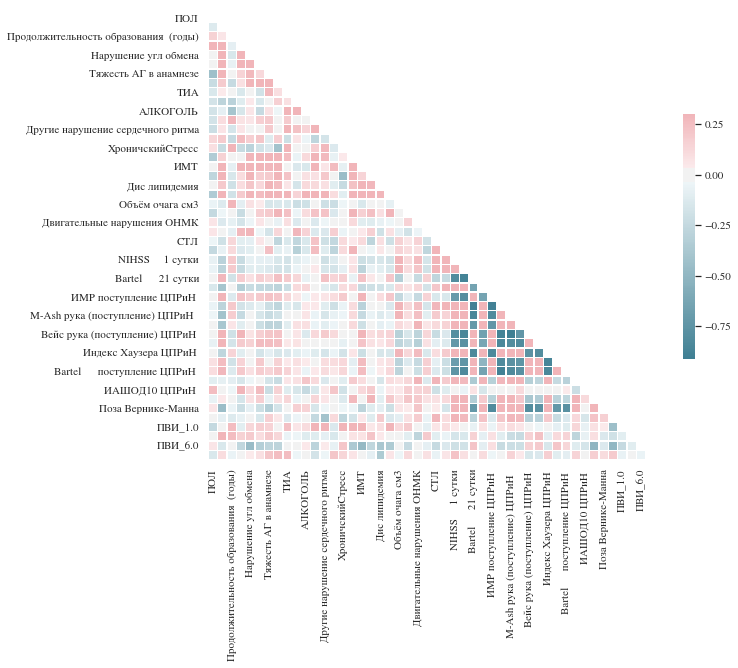

In [85]:
import matplotlib

matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)

corr = X[features].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [86]:
logit_model = sm.Logit(y,X)
result = logit_model.fit_regularized(alpha=0.5)
result.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.29737790436204814
            Iterations: 172
            Function evaluations: 185
            Gradient evaluations: 172


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           target binar   No. Observations:                   51
Model:                          Logit   Df Residuals:                       27
Method:                           MLE   Df Model:                           23
Date:                Mon, 18 Mar 2019   Pseudo R-squ.:                  0.7945
Time:                        16:04:43   Log-Likelihood:                -7.0194
converged:                       True   LL-Null:                       -34.155
                                        LLR p-value:                 0.0002458
=============================================================================================================================
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
ПОЛ                                                           0.3859      1.264      0.305      0.760      -2.092       2.864
ВОЗРАСТ                                                      -0.0724      0.094     -0.770      0.441      -0.257       0.112
Продолжительность образования  (годы)                        -0.0345      0.228     -0.151      0.880      -0.482       0.413
Метобол с-м                                                        0        nan        nan        nan         nan         nan
Нарушение угл обмена                                          1.6384      1.817      0.902      0.367      -1.924       5.200
СД                                                            0.4015      2.173      0.185      0.853      -3.857       4.660
Тяжесть АГ в анамнезе                                              0        nan        nan        nan         nan         nan
Длительность АГ                                              -0.0606      0.157     -0.386      0.699      -0.368       0.247
ТИА                                                                0        nan        nan        nan         nan         nan
КУРЕНИЕ                                                      -0.1218      1.736     -0.070      0.944      -3.524       3.280
АЛКОГОЛЬ                                                     -0.4146      1.657     -0.250      0.802      -3.662       2.833
Неревматическая фибрилляция предсердий (МКБ I48)                   0        nan        nan        nan         nan         nan
Другие нарушение сердечного ритма                                  0        nan        nan        nan         nan         nan
Низкая физическая активность                                 -5.6121      2.855     -1.966      0.049     -11.207      -0.017
ХроничскийСтресс                                                   0        nan        nan        nan         nan         nan
Количество потенциальных источников кардиогенной эмболии      0.7860      0.992      0.793      0.428      -1.157       2.729
ИМТ                                                          -0.1635      0.159     -1.029      0.303      -0.475       0.148
Количество НФР                                                     0        nan        nan        nan         nan         nan
Дис липидемия                                                      0        nan        nan        nan         nan         nan
Общее Количествово ФР                                              0        nan        nan        nan         nan         nan
Объём очага см3                                               0.0379      0.040      0.956      0.339      -0.040       0.116
ГТИ                                                                0        nan        nan        nan         nan         nan
Двигательные нарушения ОНМК                                        0        nan        nan 

In [87]:
# тут тоже плохо
y=df['target'][df['target'].notna()]

logit_model = sm.OLS(y,X)
result = logit_model.fit_regularized(alpha=0.05)
print(result.params)

ПОЛ                                                          0.000000
ВОЗРАСТ                                                      0.024413
Продолжительность образования  (годы)                        0.000000
Метобол с-м                                                  0.000000
Нарушение угл обмена                                         0.000000
СД                                                           0.000000
Тяжесть АГ в анамнезе                                        0.000000
Длительность АГ                                             -0.020831
ТИА                                                          0.000000
КУРЕНИЕ                                                      0.000000
АЛКОГОЛЬ                                                     0.000000
Неревматическая фибрилляция предсердий (МКБ I48)            -0.169943
Другие нарушение сердечного ритма                            0.000000
Низкая физическая активность                                -0.394701
ХроничскийСтресс    

In [88]:
# посмотрим на селект, и на нем же затренируемся :)))
# тип мы не переобучились
clf = sklearn.linear_model.LogisticRegression(random_state=RNG, penalty='l1')
sfm = SelectFromModel(clf, threshold=0.01)
sfm.fit(X, y)
n_features = sfm.transform(X).shape[1]

In [89]:
X.columns[sfm.get_support()]

Index(['ВОЗРАСТ ', 'Продолжительность образования  (годы)',
       'Нарушение угл обмена', 'СД', 'Длительность АГ ', 'АЛКОГОЛЬ',
       'Низкая физическая активность ',
       'Количество потенциальных источников кардиогенной эмболии ', 'ИМТ',
       'Количество НФР ', 'Общее Количествово ФР', 'Объём очага см3',
       'NIHSS     1 сутки', 'NIHSS    21 сутки ', 'Bаrtеl      21 сутки',
       'Renk 21 сутки', 'ИМР поступление ЦПРиН ', 'NIHSS  поступл ЦПРиН ',
       'M-Ash рука (поступление) ЦПРиН  ', 'Вейс рука (поступление) ЦПРиН ',
       'Индекс Хаузера ЦПРиН ', 'Bаrtеl      поступление ЦПРиН ',
       'Псевдобульбарный с-м ЦПРиН ', 'ИАШОД10 ЦПРиН ',
       'Симптомы орального автоматизма', 'ПВИ_2.0', ' АТ МАГ'],
      dtype='object')

In [90]:
temp_list_1=['ВОЗРАСТ ', 
             'Продолжительность образования  (годы)',
             'Нарушение угл обмена', 'СД', 'Длительность АГ ', 'АЛКОГОЛЬ',
             'Низкая физическая активность ',
             'Количество потенциальных источников кардиогенной эмболии ', 'ИМТ',
             'Количество НФР ', 'Общее Количествово ФР', 'Объём очага см3',
             'NIHSS     1 сутки', 'NIHSS    21 сутки ', 'Bаrtеl      21 сутки',
             'Renk 21 сутки', 'ИМР поступление ЦПРиН ', 'NIHSS  поступл ЦПРиН ',
             'M-Ash рука (поступление) ЦПРиН  ', 'Вейс рука (поступление) ЦПРиН ',
             'Индекс Хаузера ЦПРиН ', 'Bаrtеl      поступление ЦПРиН ',
             'Псевдобульбарный с-м ЦПРиН ', 'ИАШОД10 ЦПРиН ',
             'Симптомы орального автоматизма', 'ПВИ_2.0', ' АТ МАГ']

In [91]:
logit_model = sm.Logit(df['target binar'], X[temp_list_1])
result = logit_model.fit_regularized(alpha=0.6)
result.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3297206523540907
            Iterations: 123
            Function evaluations: 136
            Gradient evaluations: 123


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           target binar   No. Observations:                   51
Model:                          Logit   Df Residuals:                       30
Method:                           MLE   Df Model:                           20
Date:                Mon, 18 Mar 2019   Pseudo R-squ.:                  0.7404
Time:                        16:04:45   Log-Likelihood:                -8.8654
converged:                       True   LL-Null:                       -34.155
                                        LLR p-value:                 0.0001829
=============================================================================================================================
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
ВОЗРАСТ                                                      -0.0681      0.077     -0.883      0.377      -0.219       0.083
Продолжительность образования  (годы)                        -0.0478      0.185     -0.259      0.796      -0.410       0.314
Нарушение угл обмена                                          1.1676      1.532      0.762      0.446      -1.836       4.171
СД                                                            0.9913      1.712      0.579      0.563      -2.364       4.347
Длительность АГ                                              -0.0738      0.132     -0.560      0.576      -0.332       0.184
АЛКОГОЛЬ                                                     -0.2700      1.466     -0.184      0.854      -3.143       2.603
Низкая физическая активность                                 -5.1610      2.412     -2.140      0.032      -9.889      -0.433
Количество потенциальных источников кардиогенной эмболии      0.5037      0.867      0.581      0.561      -1.196       2.203
ИМТ                                                          -0.1425      0.150     -0.950      0.342      -0.437       0.152
Количество НФР                                                     0        nan        nan        nan         nan         nan
Общее Количествово ФР                                              0        nan        nan        nan         nan         nan
Объём очага см3                                               0.0350      0.031      1.119      0.263      -0.026       0.096
NIHSS     1 сутки                                                  0        nan        nan        nan         nan         nan
NIHSS    21 сутки                                            -0.1252      0.451     -0.278      0.781      -1.008       0.758
Bаrtеl      21 сутки                                          0.0627      0.124      0.505      0.614      -0.181       0.306
Renk 21 сутки                                                 0.3167      1.341      0.236      0.813      -2.312       2.945
ИМР поступление ЦПРиН                                              0        nan        nan        nan         nan         nan
NIHSS  поступл ЦПРиН                                          0.6311      0.635      0.994      0.320      -0.613       1.875
M-Ash рука (поступление) ЦПРиН                               -0.5844      1.257     -0.465      0.642      -3.048       1.879
Вейс рука (поступление) ЦПРиН                                      0        nan        nan        nan         nan         nan
Индекс Хаузера ЦПРиН                                          0.0112      0.720      0.016      0.988      -1.400       1.422
Bаrtеl      поступление ЦПРиН                                -0.0264      0.102     -0.259      0.795      -0.226       0.173
Псевдобульбарный с-м ЦПРиН                                    1.6393      1.480      1.107 

In [92]:
# посмотрим на 1 переменной чисто ради интереса
logit_model = sm.Logit(df['target binar'], X['NIHSS    21 сутки '])
result = logit_model.fit_regularized()
print(np.exp(result.params),result.pvalues,np.exp(result.conf_int()))

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6334923481799316
            Iterations: 5
            Function evaluations: 7
            Gradient evaluations: 5
NIHSS    21 сутки     1.069326
dtype: float64 NIHSS    21 сутки     0.019074
dtype: float64                            0         1
NIHSS    21 сутки   1.011044  1.130968


In [93]:
# для этой переменной можно посчитать odds ratio и confidence interval
np.exp(result.conf_int())

,0,1
NIHSS 21 сутки,1.011044,1.130968


## Посмотрим, что выберет грид серч

In [94]:
k = [5, 7, 9, 11, 13, 15]
knn = KNeighborsClassifier(n_jobs=-1)
elnet = LogisticRegression(random_state=RNG, max_iter = 3000)
rfr = RandomForestClassifier(n_jobs=-1, random_state=RNG)

pipe_clf = Pipeline([
    ('VarTh', VarianceThreshold()),
    ('dim_reduction', SelectKBest(f_classif)),
    ('clf', KNeighborsClassifier()),
])

param_grid = [
    {
            'dim_reduction': [SelectKBest(chi2), SelectKBest(f_classif)],
            'dim_reduction__k': k,
            'clf': [knn],
            'clf__n_neighbors': [4, 5, 8, 10]
        },       
    {
            'dim_reduction': [SelectKBest(chi2), SelectKBest(f_classif)],
            'dim_reduction__k': k,
            'clf': [elnet],
            'clf__penalty':['l1', 'l2'],
            'clf__class_weight':['balanced', None]

        },
        {
            'dim_reduction': [SelectKBest(chi2), SelectKBest(f_classif)],
            'dim_reduction__k': k,
            'clf': [rfr],
            'clf__criterion' :['gini', 'entropy']
        }
    ]

CVgrid = GridSearchCV(estimator=pipe_clf, 
                      param_grid=param_grid, 
                      cv=4, 
                      scoring='roc_auc', 
                      n_jobs=-1, 
                      verbose=0)

CVgrid.fit(X, df['target binar'])
print ('Model best score:', CVgrid.best_score_ )
CVgrid.best_params_

Model best score: 0.8170168067226891


{'clf': LogisticRegression(C=1.0, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=3000,
           multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
           solver='warn', tol=0.0001, verbose=0, warm_start=False),
 'clf__class_weight': 'balanced',
 'clf__penalty': 'l2',
 'dim_reduction': SelectKBest(k=5, score_func=<function f_classif at 0x7f97251792f0>),
 'dim_reduction__k': 5}

In [95]:
y = df['target binar']

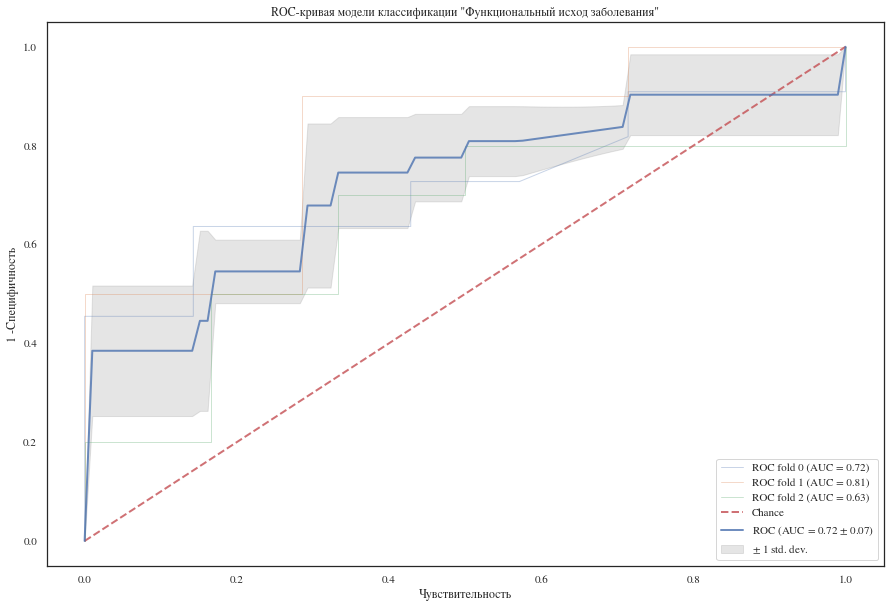

In [96]:
n_samples, n_features = X.shape

cv = StratifiedKFold(n_splits=3)
classifier = clf = CVgrid.best_estimator_

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(15, 10))
i = 0
for train, test in cv.split(X, y.astype(int)):
    probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')


plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Чувствительность')
plt.ylabel('1 -Специфичность')
plt.title('ROC-кривая модели классификации "Функциональный исход заболевания"')
plt.legend(loc="lower right")
plt.show()